<a href="https://colab.research.google.com/github/weswest/MSDS422/blob/main/MSDS_422_Assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0 Project Overview

This workbook performs basic introductory EDA on the Ames, Iowa Housing dataset available on Kaggle: [House Prices - Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

This is Assignment 2 for the Northwestern MSDS-422 Practical Machine Learning course.  Abbreviated instructions for this assignment:

You are to produce linear regressions that predict sale prices in the Ames, Iowa dataset.  In particular: 

1. Conduct your analysis using a cross-validation design.
2. Conduct / improve upon previous EDA.
3. Build models with many variables.
4. Transform and feature engineer as appropriate.
5. Build at a minimum the following regression models: Lasso, Ridge, ElasticNet
6. Conduct hyperparameter tuning for the ElasticNet
7. Evaluate performance of the model using the Kaggle metric upon which your scores are evaluated.
8. Submit at least two models to Kaggle.com for evaluation. Provider your Kaggle.com user name and screen snapshots of your Kaggle scores.




# Workbook Structure

This work pulls heavily from Assignment 1, which was a deep dive on EDA of the Ames dataset.

## Considerations for analysis vs EDA

Assignment 1 was limited to exploration of the "train" file provided in the Kaggle competition; this time we will need to also consider the "test" file.  Namely, as we create rules for handling outliers, missing values, etc we will need to
- Create our treatment using the train dataset
- Apply the treatment to the test dataset

The focus of this assignment is explicitly on **linear regression**, without taking advantage of dimension reduction features like PCA, or lasso regressions.

## Overall layout

0. Setup - loading libraries, data
1. Research into DV (train only)
2. Treatment of outliers and missing values
3. Feature research and generation
4. IV and DV feature scaling (as necessary)
5. Model development and testing


# 0 Setup


## 0.1 Setup - Load Libraries

In [ ]:
import pandas as pd
import numpy as np
import math
import statistics
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm, skew

import warnings
warnings.filterwarnings('ignore')

## 0.2 Setup - Operating Environment
This code allows the Colab notebook to access my Google Drive files.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
try:
  os.chdir("drive/My Drive/MSDS/422/Ames")
except:
  pass

Mounted at /content/drive


## 0.3 Setup - Read in Data
Note: the Kaggle dataset already splits the housing data into "train" and "test" sets.  This assignment allows us to ignore the test set for now

In [ ]:
df_train = pd.read_csv('Data/train.csv')
df_test = pd.read_csv('Data/test.csv')

In [ ]:
print(df_train.shape)
print(df_train.select_dtypes(include=np.number).shape)
print(df_train.select_dtypes(exclude=np.number).shape)

print('In the training dataset we have 1460 observations, 81 variables: 38 number and 43 categorical')

print(df_test.shape)
print(df_test.select_dtypes(include=np.number).shape)
print(df_test.select_dtypes(exclude=np.number).shape)

print('In the training dataset we have 1459 observations, 80 variables: 37 number and 43 categorical')

(1460, 81)
(1460, 38)
(1460, 43)
In the training dataset we have 1460 observations, 81 variables: 38 number and 43 categorical
(1459, 80)
(1459, 37)
(1459, 43)
In the training dataset we have 1459 observations, 80 variables: 37 number and 43 categorical


# 1 Explore the Dependent Variable (Sale Price)


## 1.1 DV Description

The code below shows that there is right skew: the mean of \$181k is higher than the median of \$163k.  Also, this highlights the range of sale prices from \$35k to \$755k

In [ ]:
# 1.1 The code below pulls out the standard mean, median, min/max distributions for our key variable

print(df_train['SalePrice'].describe())

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


## 1.2 DV Box Plot

The box and whisker plot is useful for identifying the typical values, as well as the outliers.

The graph below shows that there are a number of sale price outliers on the upper end of the graph, which is not unexpected given the right skew.

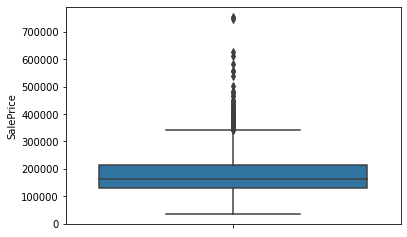

In [ ]:
# 1.2 The code below reveals a large number of outliers, especially on the upper end
# This sort of result is indicative of a probable right skew

sns.boxplot( y=df_train["SalePrice"])
#plt.show()

## 1.3 DV Distribution

The next handful of code blocks get into what the DV distribution looks like.  The first code block directly shows the PD of Sale Price.  The second also overlays a normal distribution on top of the graph, to better understand how far away from normal the graph looks.

Spoiler: the Sale Price is not normal.

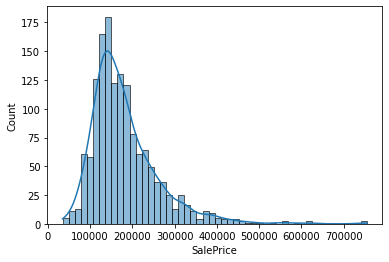

In [ ]:
# 1.3 This graph below attempts to show the probability distribution of the DV
# As noted above, it looks likely there is right skew here

sns.histplot(x=df_train['SalePrice'], bins=50, kde=True)


 mu = 180921.20 and sigma = 79415.29



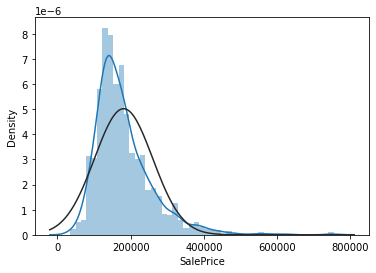

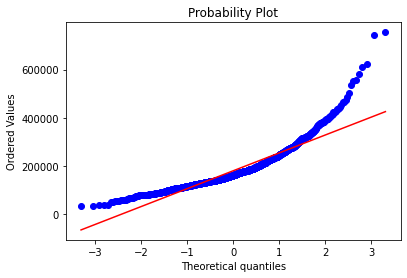

In [ ]:
# Base function pulled from https://www.kaggle.com/anupjana/top-10-ames-house-pricing-stacked-regression
# and subsequently edited

# This code overlays the probability distribution of the key variable with a normal curve

def check_skewness(frame, col):
    sns.distplot(frame[col] , fit=norm);
    fig = plt.figure()
    res = stats.probplot(frame[col], plot=plt)
    # Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(frame[col])
    print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
    
check_skewness(df_train, 'SalePrice')

## 1.4 DV Treatment - Log Transform
Note: this isn't specifically recommended within the assignment, but this is a useful approach to see if the transformation will result in a more normal distribution.  In this case, it very clearly does.

Note: log transformations convert the relationship between values from additive (values of 150 and 225 are 75 units apart) to multiplicative (ln(150) vs ln(225) is approximately a 50% increase).


 mu = 12.02 and sigma = 0.40



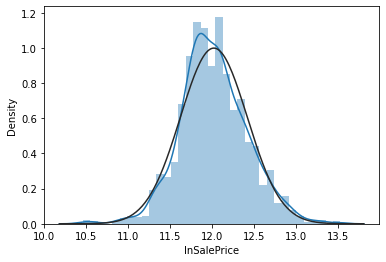

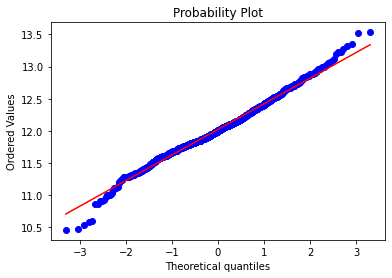

In [ ]:
df_train['lnSalePrice'] = np.log(df_train['SalePrice'])
check_skewness(df_train, 'lnSalePrice')

# 2 Investigate Missing Data and Outliers

## 2.1 Investigate Missing Data



### 2.1.1 Naive Missing Data Research
Before digging into anything that we know about the data, let's take a look at missing values.

Hat tip to Dr Larry for the code used to graph missing data.

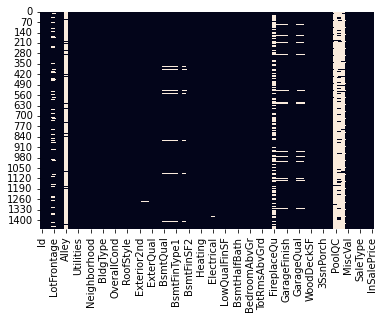

In [ ]:
# Hat tip: https://github.com/dustoff06/MI/blob/main/MI%20Final%209%201%202021.ipynb

sns.heatmap(df_train.isnull(), cbar=False)

In [ ]:
# Quick function that produces the 10 fields with the highest percentage of missing elements

def pct_missing(frame):
  temp = frame.isnull().sum() # This row generates a vector of Null counts
  temp = temp / len(frame) # len(df_train) is the length of the dataset.  Dividing == %
  # This prints out the top 10 fields with missing rows
  return(temp.sort_values(ascending=False).head(10))

print(pct_missing(df_train))
print(pct_missing(df_test))

PoolQC          0.995205
MiscFeature     0.963014
Alley           0.937671
Fence           0.807534
FireplaceQu     0.472603
LotFrontage     0.177397
GarageQual      0.055479
GarageCond      0.055479
GarageFinish    0.055479
GarageType      0.055479
dtype: float64
PoolQC          0.997944
MiscFeature     0.965045
Alley           0.926662
Fence           0.801234
FireplaceQu     0.500343
LotFrontage     0.155586
GarageCond      0.053461
GarageQual      0.053461
GarageYrBlt     0.053461
GarageFinish    0.053461
dtype: float64


**Conclusion:** There are a number of data fields with many missing values

### 2.1.2 Recharacterize "NA" as "No Feature" as appropriate.

Some very light research into the data dictionary indicates that many of the fields with missing values have "NA" encoded when in reality it's "No Feature".  It's important to retain these items, e.g., we don't want to delete the 99% of records without a pool.  It also doesn't make sense to backfill these values with, e.g., the average observed size of the pool.

The code below runs through all of the fields where the data dictionary clearly indicates that "NA" indicates "none of the feature"

LotFrontage    0.177397
GarageYrBlt    0.055479
MasVnrArea     0.005479
Electrical     0.000685
lnSalePrice    0.000000
Foundation     0.000000
RoofMatl       0.000000
Exterior1st    0.000000
Exterior2nd    0.000000
MasVnrType     0.000000
dtype: float64

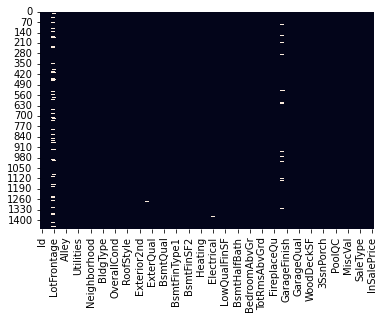

In [ ]:
none_fields = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu',
                 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'MasVnrType', 'PoolQC', 'Fence', 'MiscFeature']
df_train[none_fields] = df_train[none_fields].fillna('None')

sns.heatmap(df_train.isnull(), cbar=False)
pct_missing(df_train)

LotFrontage     0.155586
GarageYrBlt     0.053461
MasVnrArea      0.010281
MSZoning        0.002742
Functional      0.001371
BsmtHalfBath    0.001371
BsmtFullBath    0.001371
Utilities       0.001371
BsmtFinSF1      0.000685
Exterior1st     0.000685
dtype: float64

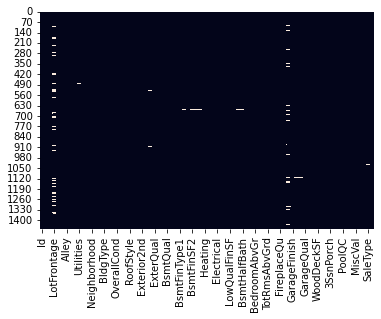

In [ ]:
df_test[none_fields] = df_test[none_fields].fillna('None')

sns.heatmap(df_test.isnull(), cbar=False)
pct_missing(df_test)

**Conclusion:** Filling in these known NAs removes nearly all of the missing values from the dataset.  The remaining columns require more consideration.

### 2.1.3 Determine what to do about LotFrontage
LotFrontage is the linear feet of the property attached to a street.  There's no a priori reason from the data dictionary why this would be null.

Others who have worked with the Ames dataset (see references above) fill in the lot frontage based on the neighborhood.  That seems like a smart approach, but it may not be the best.

Below I test whether the Building Type (e.g., Single Family or Townhouse) may be a better identifier.  The answer is clearly not.

The other thing I'm considering is whether we could identify an interim model to predict lot frontage from the lot area (e.g., if we assume Lot Area is a square then frontage = sqrt(Area).  First blush it looks like that wouldn't work great, plus that raises complications.  

**Conclusion:** To get through the day I'll follow the learnings of those who came before me and backfill to equal the neighborhood median.

**Note**: We need to use the df_train dataset's median to fill in the df_test's missing values here.

In [ ]:
df_train[df_train['LotFrontage'].isna()].head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,lnSalePrice
7,8,60,RL,NaN,10382,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,...,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,None,None,Shed,350,11,2009,WD,Normal,200000,12.206073
12,13,20,RL,NaN,12968,Pave,None,IR2,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,1Fam,1Story,5,6,1962,1962,Hip,CompShg,HdBoard,Plywood,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,737,Unf,0,175,912,GasA,...,SBrkr,912,0,0,912,1,0,1,0,2,1,TA,4,Typ,0,None,Detchd,1962.0,Unf,1,352,TA,TA,Y,140,0,0,0,176,0,None,None,None,0,9,2008,WD,Normal,144000,11.877569
14,15,20,RL,NaN,10920,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,MetalSd,MetalSd,BrkFace,212.0,TA,TA,CBlock,TA,TA,No,BLQ,733,Unf,0,520,1253,GasA,...,SBrkr,1253,0,0,1253,1,0,1,1,2,1,TA,5,Typ,1,Fa,Attchd,1960.0,RFn,1,352,TA,TA,Y,0,213,176,0,0,0,None,GdWo,None,0,5,2008,WD,Normal,157000,11.964001
16,17,20,RL,NaN,11241,Pave,None,IR1,Lvl,AllPub,CulDSac,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,7,1970,1970,Gable,CompShg,Wd Sdng,Wd Sdng,BrkFace,180.0,TA,TA,CBlock,TA,TA,No,ALQ,578,Unf,0,426,1004,GasA,...,SBrkr,1004,0,0,1004,1,0,1,0,2,1,TA,5,Typ,1,TA,Attchd,1970.0,Fin,2,480,TA,TA,Y,0,0,0,0,0,0,None,None,Shed,700,3,2010,WD,Normal,149000,11.911702
24,25,20,RL,NaN,8246,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,1Fam,1Story,5,8,1968,2001,Gable,CompShg,Plywood,Plywood,None,0.0,TA,Gd,CBlock,TA,TA,Mn,Rec,188,ALQ,668,204,1060,GasA,...,SBrkr,1060,0,0,1060,1,0,1,0,3,1,Gd,6,Typ,1,TA,Attchd,1968.0,Unf,1,270,TA,TA,Y,406,90,0,0,0,0,None,MnPrv,None,0,5,2010,WD,Normal,154000,11.944708
31,32,20,RL,NaN,8544,Pave,None,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,Norm,Norm,1Fam,1Story,5,6,1966,2006,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0,Unf,0,1228,1228,GasA,...,SBrkr,1228,0,0,1228,0,0,1,1,3,1,Gd,6,Typ,0,None,Attchd,1966.0,Unf,1,271,TA,TA,Y,0,65,0,0,0,0,None,MnPrv,None,0,6,2008,WD,Normal,149350,11.914048
42,43,85,RL,NaN,9180,Pave,None,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,Norm,1Fam,SFoyer,5,7,1983,1983,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,CBlock,Gd,TA,Av,ALQ,747,LwQ,93,0,840,GasA,...,SBrkr,884,0,0,884,1,0,1,0,2,1,Gd,5,Typ,0,None,Attchd,1983.0,RFn,2,504,TA,Gd,Y,240,0,0,0,0,0,None,MnPrv,None,0,12,2007,WD,Normal,144000,11.877569
43,44,20,RL,NaN,9200,Pave,None,IR1,Lvl,AllPub,CulDSac,Gtl,CollgCr,Norm,Norm,1Fam,1Story,5,6,1975,1980,Hip,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,Gd,TA,Av,LwQ,280,BLQ,491,167,938,GasA,...,SBrkr,938,0,0,938,1,0,1,0,3,1,TA,5,Typ,0,None,Detchd,1977.0,Unf,1,308,TA,TA,Y,145,0,0,0,0,0,None,MnPrv,None,0,7,2008,WD,Normal,130250,11.777211
50,51,60,RL,NaN,13869,Pave,None,IR2,Lvl,AllPub,Corner,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1997,1997,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,Av,GLQ,182,Unf,0,612,794,GasA,...,SBrkr,794,676,0,1470,0,1,2,0,3,1,TA,6,Typ,0,None,Attchd,1997.0,Fin,2,388,TA,TA,Y,0,75,0,0,0,0,None,None,None,0,7,2007,WD,Normal,177000,12.083905
64,65,60,RL,NaN,9375,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5

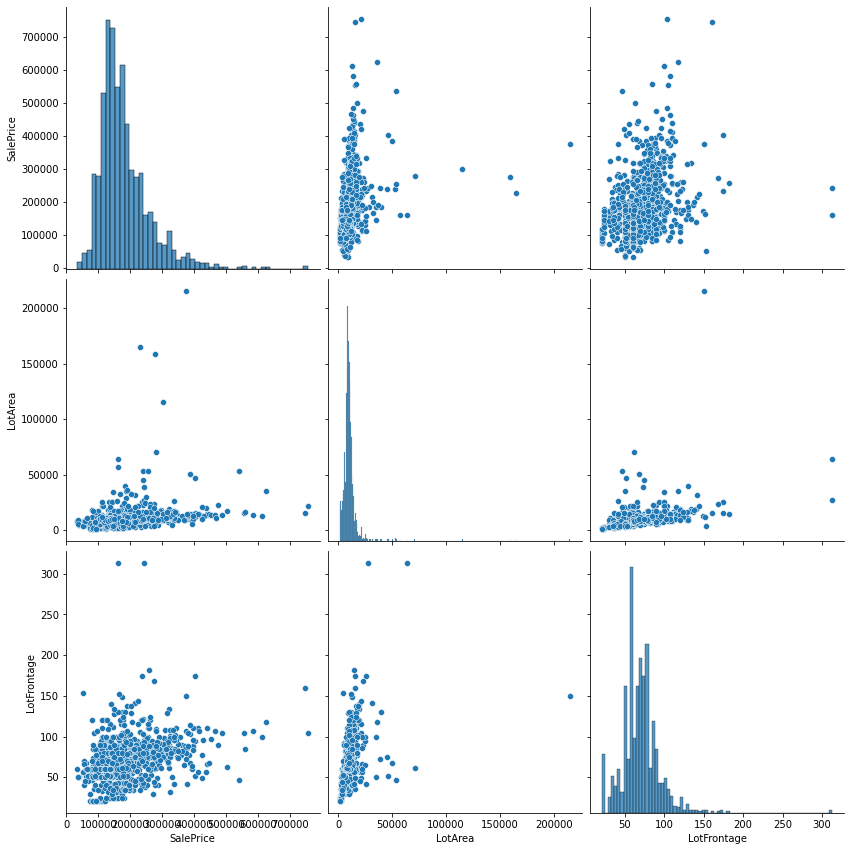

In [ ]:
# The pairplot code produces all of the permutations of scatterplots for the input fields

pairs = ['SalePrice', 'LotArea', 'LotFrontage']
sns.pairplot(df_train[pairs], size = 4)
plt.show()
# Note we should probably come back to this for some of the outliers.

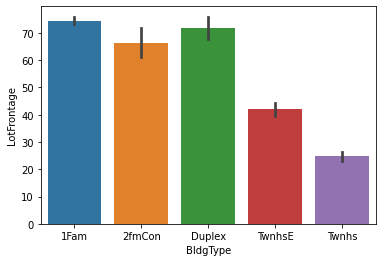

In [ ]:

sns.barplot(x = df_train['BldgType'], y = df_train['LotFrontage'])


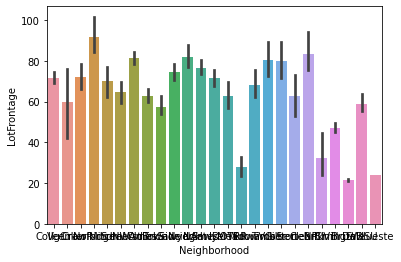

In [ ]:
sns.barplot(x = df_train['Neighborhood'], y = df_train['LotFrontage'])

In [ ]:
# Hat tip: https://www.kaggle.com/anupjana/top-10-ames-house-pricing-stacked-regression
df_train["LotFrontage"] = df_train.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
pct_missing(df_train)

GarageYrBlt    0.055479
MasVnrArea     0.005479
Electrical     0.000685
Foundation     0.000000
RoofStyle      0.000000
RoofMatl       0.000000
Exterior1st    0.000000
Exterior2nd    0.000000
MasVnrType     0.000000
ExterQual      0.000000
dtype: float64

In [ ]:
df_test["LotFrontage"] = df_train.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
pct_missing(df_test)

GarageYrBlt     0.053461
MasVnrArea      0.010281
MSZoning        0.002742
Utilities       0.001371
Functional      0.001371
BsmtFullBath    0.001371
BsmtHalfBath    0.001371
BsmtFinSF1      0.000685
KitchenQual     0.000685
Exterior2nd     0.000685
dtype: float64

### 2.1.4 Determine How to Handle GarageYrBlt

Ok, so these missing values are examples where there is no garage, so of course there's no year built.  What's the best way to fill these in?

I have to presume that at a later stage of feature selection the way we'd expect to use "GarageYrBlt" is to indicate whether the garage was built after the house (e.g., an addon).  If that's the case, the likely defining variable will be whether House Year = Garage Year or not.  So we will set Garage Year NAs to House Year.

In [ ]:
df_train[df_train['GarageYrBlt'].isna()].head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,lnSalePrice
39,40,90,RL,65.0,6040,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,Duplex,1Story,4,5,1955,1955,Gable,CompShg,AsbShng,Plywood,None,0.0,TA,TA,PConc,None,None,None,None,0,None,0,0,0,GasA,...,FuseP,1152,0,0,1152,0,0,2,0,2,2,Fa,6,Typ,0,None,None,NaN,None,0,0,None,None,N,0,0,0,0,0,0,None,None,None,0,6,2008,WD,AdjLand,82000,11.314475
48,49,190,RM,33.0,4456,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,2fmCon,2Story,4,5,1920,2008,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,736,736,GasA,...,SBrkr,736,716,0,1452,0,0,2,0,2,3,TA,8,Typ,0,None,None,NaN,None,0,0,None,None,N,0,0,102,0,0,0,None,None,None,0,6,2009,New,Partial,113000,11.635143
78,79,90,RL,72.0,10778,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,Duplex,1Story,4,5,1968,1968,Hip,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0,Unf,0,1768,1768,GasA,...,SBrkr,1768,0,0,1768,0,0,2,0,4,2,TA,8,Typ,0,None,None,NaN,None,0,0,None,None,Y,0,0,0,0,0,0,None,None,None,0,4,2010,WD,Normal,136500,11.824080
88,89,50,C (all),105.0,8470,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,IDOTRR,Feedr,Feedr,1Fam,1.5Fin,3,2,1915,1982,Hip,CompShg,Plywood,Plywood,None,0.0,Fa,Fa,CBlock,TA,Fa,No,Unf,0,Unf,0,1013,1013,GasA,...,SBrkr,1013,0,513,1526,0,0,1,0,2,1,Fa,6,Typ,0,None,None,NaN,None,0,0,None,None,N,0,0,156,0,0,0,None,MnPrv,None,0,10,2009,ConLD,Abnorml,85000,11.350407
89,90,20,RL,60.0,8070,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,1Story,4,5,1994,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,588,Unf,0,402,990,GasA,...,SBrkr,990,0,0,990,1,0,1,0,3,1,TA,5,Typ,0,None,None,NaN,None,0,0,None,None,Y,0,0,0,0,0,0,None,None,None,0,8,2007,WD,Normal,123600,11.724806
99,100,20,RL,77.0,9320,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,4,5,1959,1959,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,569,Unf,0,381,950,GasA,...,SBrkr,1225,0,0,1225,1,0,1,1,3,1,TA,6,Typ,0,None,None,NaN,None,0,0,None,None,Y,352,0,0,0,0,0,None,None,Shed,400,1,2010,WD,Normal,128950,11.767180
108,109,50,RM,85.0,8500,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,IDOTRR,Artery,Norm,1Fam,1.5Fin,5,7,1919,2005,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0,Unf,0,793,793,GasW,...,FuseF,997,520,0,1517,0,0,2,0,3,1,Fa,7,Typ,0,None,None,NaN,None,0,0,None,None,N,0,0,144,0,0,0,None,None,None,0,8,2007,WD,Normal,115000,11.652687
125,126,190,RM,60.0,6780,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,2fmCon,1.5Fin,6,8,1935,1982,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,Fa,CBlock,TA,TA,Av,GLQ,490,Unf,0,30,520,GasA,...,SBrkr,520,0,234,754,1,0,1,0,2,1,TA,5,Typ,0,None,None,NaN,None,0,0,None,None,N,53,0,0,0,0,0,None,None,None,0,6,2006,WD,Normal,84500,11.344507
127,128,45,RM,55.0,4388,Pave,None,IR1,Bnk,AllPub,Inside,Gtl,OldTown,Feedr,Norm,1Fam,1.5Unf,5,7,1930,1950,Gable,CompShg,WdShing,Wd Sdng,None,0.0,TA,Gd,BrkTil,TA,TA,No,LwQ,116,Unf,0,556,672,GasA,...,SBrkr,840,0,0,840,0,0,1,0,3,1,TA,5,Typ,1,TA,None,NaN,None,0,0,None,None,N,0,0,0,0,0,0,None,None,None,0,6,2007,WD,Normal,87000,11.373663
140,141,20,RL,70.0,10500,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,NAmes,Norm,Norm,1Fam,1Story,4,5,1971,1971,Gable,

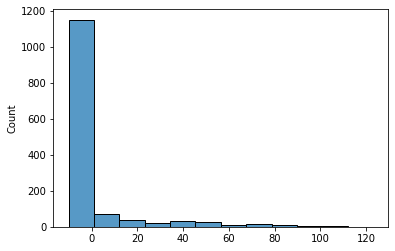

In [ ]:
# This code confirms that in nearly all cases the Garage and House were built in the same year

test1 = df_train['GarageYrBlt'] - df_train['YearBuilt']
sns.histplot(test1)

In [ ]:
df_train['GarageYrBlt'] = df_train['GarageYrBlt'].fillna(df_train['YearBuilt'])
pct_missing(df_train)

MasVnrArea     0.005479
Electrical     0.000685
lnSalePrice    0.000000
Foundation     0.000000
RoofMatl       0.000000
Exterior1st    0.000000
Exterior2nd    0.000000
MasVnrType     0.000000
ExterQual      0.000000
ExterCond      0.000000
dtype: float64

In [ ]:
df_test['GarageYrBlt'] = df_test['GarageYrBlt'].fillna(df_test['YearBuilt'])
pct_missing(df_test)

MasVnrArea      0.010281
MSZoning        0.002742
Functional      0.001371
BsmtHalfBath    0.001371
BsmtFullBath    0.001371
Utilities       0.001371
GarageCars      0.000685
KitchenQual     0.000685
Exterior2nd     0.000685
Exterior1st     0.000685
dtype: float64

### 2.1.5 Determine How To Handle MasVnrArea

These NAs are where the Masonry Veneer is "None", so these should just be zero.

In [ ]:
df_train['MasVnrArea'] = df_train['MasVnrArea'].fillna(0)
pct_missing(df_train)

Electrical     0.000685
lnSalePrice    0.000000
Foundation     0.000000
RoofMatl       0.000000
Exterior1st    0.000000
Exterior2nd    0.000000
MasVnrType     0.000000
MasVnrArea     0.000000
ExterQual      0.000000
ExterCond      0.000000
dtype: float64

In [ ]:
df_test['MasVnrArea'] = df_test['MasVnrArea'].fillna(0)
pct_missing(df_test)

MSZoning        0.002742
Functional      0.001371
Utilities       0.001371
BsmtFullBath    0.001371
BsmtHalfBath    0.001371
TotalBsmtSF     0.000685
SaleType        0.000685
GarageArea      0.000685
Exterior1st     0.000685
BsmtUnfSF       0.000685
dtype: float64

### 2.1.6 Determine How To Handle Electrical

The most common Electrical value is 'SBrkr' by far.  So fill with that.

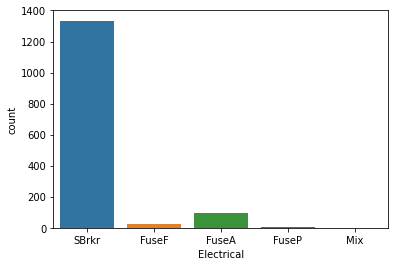

In [ ]:
sns.countplot(x=df_train['Electrical'])

In [ ]:
df_train['Electrical'] = df_train['Electrical'].fillna('SBrkr')
pct_missing(df_train)

lnSalePrice     0.0
YearRemodAdd    0.0
RoofMatl        0.0
Exterior1st     0.0
Exterior2nd     0.0
MasVnrType      0.0
MasVnrArea      0.0
ExterQual       0.0
ExterCond       0.0
Foundation      0.0
dtype: float64

In [ ]:
df_test['Electrical'] = df_test['Electrical'].fillna('SBrkr')
pct_missing(df_test)

MSZoning        0.002742
Functional      0.001371
Utilities       0.001371
BsmtFullBath    0.001371
BsmtHalfBath    0.001371
TotalBsmtSF     0.000685
SaleType        0.000685
GarageArea      0.000685
Exterior1st     0.000685
BsmtUnfSF       0.000685
dtype: float64

### 2.1.7 Callout: Remaining Missing Values in Test Set

After applying the Training set fillna rules, there are still a number of Test observations with missing values.  Let's quickly take a look.

We can bin the missing values in two camps:
* Categorical (MSZoning, Functional, Utilities, SaleType)
* Numerical (BsmtFullBath, BsmtHalfBath, TotalBsmtSF, GarageArea, Exterior1st, BsmtUnfSF)

For Categorical, the training dataset overwhelmingly categorizes sales into specific categories, and we will fillna with those category values.

For Numeric, these generally appear to relate to missing values, so we will fill with "0".

In [ ]:
df_test[df_test.isnull().any(axis=1)]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
95,1556,50,RL,65.0,10632,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,ClearCr,Norm,Norm,1Fam,1.5Fin,5,3,1917,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,BrkTil,Gd,Fa,No,Unf,0.0,Unf,0.0,689.0,689.0,GasA,Gd,N,SBrkr,725,499,0,1224,0.0,0.0,1,1,3,1,NaN,6,Mod,0,None,Detchd,1917.0,Unf,1.0,180.0,Fa,Fa,N,0,0,248,0,0,0,None,None,None,0,1,2010,COD,Normal
455,1916,30,NaN,80.0,21780,Grvl,None,Reg,Lvl,NaN,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,2,4,1910,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,Fa,Fa,CBlock,None,None,None,None,0.0,None,0.0,0.0,0.0,GasA,TA,N,FuseA,810,0,0,810,0.0,0.0,1,0,1,1,TA,4,Min1,0,None,Detchd,1975.0,Unf,1.0,280.0,TA,TA,N,119,24,0,0,0,0,None,None,None,0,3,2009,ConLD,Normal
485,1946,20,RL,80.0,31220,Pave,None,IR1,Bnk,NaN,FR2,Gtl,Gilbert,Feedr,Norm,1Fam,1Story,6,2,1952,1952,Hip,CompShg,BrkFace,BrkFace,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,1632.0,1632.0,GasA,TA,Y,FuseA,1474,0,0,1474,0.0,0.0,1,0,3,1,TA,7,Min2,2,Gd,Attchd,1952.0,Unf,2.0,495.0,TA,TA,Y,0,0,144,0,0,0,None,None,Shed,750,5,2008,WD,Normal
660,2121,20,RM,80.0,5940,Pave,None,IR1,Lvl,AllPub,FR3,Gtl,BrkSide,Feedr,Norm,1Fam,1Story,4,7,1946,1950,Gable,CompShg,MetalSd,CBlock,None,0.0,TA,TA,PConc,None,None,None,None,NaN,None,NaN,NaN,NaN,GasA,TA,Y,FuseA,896,0,0,896,NaN,NaN,1,0,2,1,TA,4,Typ,0,None,Detchd,1946.0,Unf,1.0,280.0,TA,TA,Y,0,0,0,0,0,0,None,MnPrv,None,0,4,2008,ConLD,Abnorml
691,2152,30,RL,104.0,19550,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,5,7,1940,2007,Flat,Tar&Grv,NaN,NaN,None,0.0,TA,TA,PConc,TA,TA,Gd,ALQ,1035.0,Unf,0.0,545.0,1580.0,GasA,Ex,Y,SBrkr,1518,0,0,1518,1.0,0.0,1,0,2,1,Fa,5,Typ,2,Gd,None,1940.0,None,0.0,0.0,None,None,Y,0,39,0,0,0,0,None,None,None,0,1,2008,WD,Normal
728,2189,20,RL,85.0,47007,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,5,7,1959,1996,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,Slab,None,None,None,None,0.0,None,0.0,0.0,0.0,GasA,TA,Y,SBrkr,3820,0,0,3820,NaN,NaN,3,1,5,1,Ex,11,Typ,2,Gd,Attchd,1959.0,Unf,2.0,624.0,TA,TA,Y,0,372,0,0,0,0,None,None,None,0,7,2008,WD,Normal
756,2217,20,NaN,68.0,14584,Pave,None,Reg,Low,AllPub,Inside,Mod,IDOTRR,Norm,Norm,1Fam,1Story,1,5,1952,1952,Gable,CompShg,AsbShng,VinylSd,None,0.0,Fa,Po,Slab,None,None,None,None,0.0,None,0.0,0.0,0.0,Wall,Po,N,FuseA,733,0,0,733,0.0,0.0,1,0,2,1,Fa,4,NaN,0,None,Attchd,1952.0,Unf,2.0,487.0,Fa,Po,N,0,0,0,0,0,0,None,None,None,0,2,2008,WD,Abnorml
790,2251,70,NaN,43.0,56600,Pave,None,IR1,Low,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,2.5Unf,5,1,1900,1950,Hip,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0.0,Unf,0.0,686.0,686.0,GasA,Ex,Y,SBrkr,1150,686,0,1836,0.0,0.0,2,0,4,1,TA,7,Maj1,0,None,Detchd,1900.0,Unf,1.0,288.0,TA,Fa,N,0,0,0,0,0,0,None,None,None,0,1,2008,WD,Normal
1013,2474,50,RM,60.0,10320,Pave,Grvl,Reg,Lvl,AllPub,Corner,Gtl,IDOTRR,Artery,Norm,1Fam,1.5Fin,4,1,1910,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,Fa,Fa,CBlock,TA,Fa,No,Unf,0.0,Unf,0.0,771.0,771.0,GasA,Fa,Y,SBrkr,866,504,114,1484,0.0,0.0,2,0,3,1,TA,6,NaN,0,None,Detchd,1910.0,Unf,1.0,264.0,TA,Fa,N,14,211,0,0,84,0,None,None,None,0,9,2007,COD,Abnorml
1029,2490,20,RL,21.0,13770,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,Sawyer,Feedr,Norm,1

### 2.1.8 MSZoning Treatment

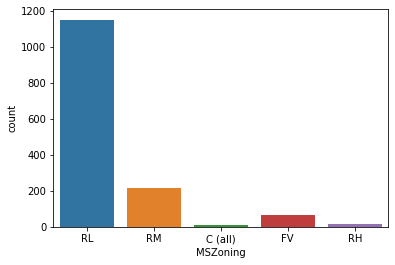

In [ ]:
sns.countplot(x=df_train['MSZoning'])

In [ ]:
df_test['MSZoning'] = df_test['MSZoning'].fillna('RL')
pct_missing(df_test)

Functional      0.001371
Utilities       0.001371
BsmtFullBath    0.001371
BsmtHalfBath    0.001371
BsmtFinSF2      0.000685
BsmtUnfSF       0.000685
TotalBsmtSF     0.000685
SaleType        0.000685
KitchenQual     0.000685
BsmtFinSF1      0.000685
dtype: float64

### 2.1.9 Functional Treatment

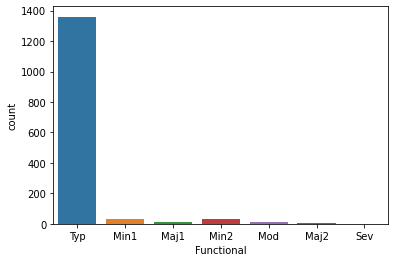

In [ ]:
sns.countplot(x=df_train['Functional'])

In [ ]:
df_test['Functional'] = df_test['Functional'].fillna('Typ')
pct_missing(df_test)

Utilities       0.001371
BsmtFullBath    0.001371
BsmtHalfBath    0.001371
BsmtFinSF2      0.000685
BsmtUnfSF       0.000685
TotalBsmtSF     0.000685
SaleType        0.000685
BsmtFinSF1      0.000685
KitchenQual     0.000685
Exterior1st     0.000685
dtype: float64

### 2.1.10 Utilities

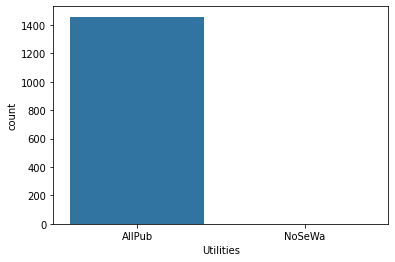

In [ ]:
sns.countplot(x=df_train['Utilities'])

In [ ]:
df_test['Utilities'] = df_test['Utilities'].fillna('AllPub')
pct_missing(df_test)

BsmtFullBath    0.001371
BsmtHalfBath    0.001371
BsmtFinSF2      0.000685
KitchenQual     0.000685
Exterior1st     0.000685
GarageCars      0.000685
GarageArea      0.000685
Exterior2nd     0.000685
BsmtFinSF1      0.000685
SaleType        0.000685
dtype: float64

### 2.1.11 SaleType Treatment

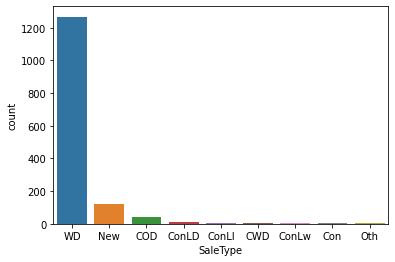

In [ ]:
sns.countplot(x=df_train['SaleType'])

In [ ]:
df_test['SaleType'] = df_test['SaleType'].fillna('WD')
pct_missing(df_test)

BsmtFullBath    0.001371
BsmtHalfBath    0.001371
BsmtFinSF2      0.000685
BsmtUnfSF       0.000685
TotalBsmtSF     0.000685
BsmtFinSF1      0.000685
KitchenQual     0.000685
Exterior1st     0.000685
GarageCars      0.000685
GarageArea      0.000685
dtype: float64

### 2.1.12 KitchenQual Treatment

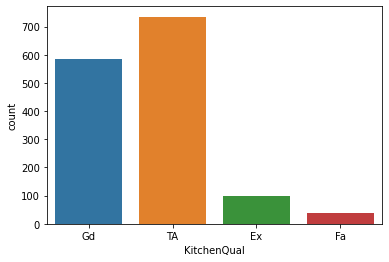

In [ ]:
sns.countplot(x=df_train['KitchenQual'])

In [ ]:
df_test['KitchenQual'] = df_test['KitchenQual'].fillna('TA')
pct_missing(df_test)

BsmtFullBath    0.001371
BsmtHalfBath    0.001371
BsmtFinSF2      0.000685
Exterior1st     0.000685
GarageCars      0.000685
GarageArea      0.000685
Exterior2nd     0.000685
BsmtUnfSF       0.000685
BsmtFinSF1      0.000685
TotalBsmtSF     0.000685
dtype: float64

### 2.1.13 Fill all remaining with 0

In [ ]:
df_test = df_test.fillna(0)
pct_missing(df_test)

SaleCondition    0.0
SaleType         0.0
RoofStyle        0.0
RoofMatl         0.0
Exterior1st      0.0
Exterior2nd      0.0
MasVnrType       0.0
MasVnrArea       0.0
ExterQual        0.0
ExterCond        0.0
dtype: float64

## 2.2 Handling Outliers

If we take a naive look at sale price, then we see there are many observations that would meet the 1.5x IQR threshold.  That said, the distribution plot shared earlier in this notebook reveals a skew towards higher-priced homes that was materially resolved by log-transforming the sale price.

So for outlier treatment, we won't exclude all of the large sale prices.

Instead, we will follow an approach of identifying which fields have outliers (using the "extreme outlier" definition of 3*IQR above/below the first and third quartiles), and then graphing the field against sale price to make a judgment whether there are outliers.

### 2.2.1 Identify the fields with 3*IQR outliers

In [ ]:
# Thanks for inspiration: https://stackoverflow.com/questions/39068214/how-to-count-outliers-for-all-columns-in-python/39068451#39068451

num_df_train = df_train.select_dtypes(include=np.number) # This creates a dataset that excludes all of the categorical variables
Q1 = num_df_train.quantile(0.25) # Creates a vector of the 1st quantile values
Q3 = num_df_train.quantile(0.75) # Creates a vector of the 3rd quantile values
IQR = Q3 - Q1 # Generates the IQR for each of the variables

# The code below implements an "extreme outlier" test.  Normal outliers would replace the "3 *" with "1.5 *"
temp = ((num_df_train < (Q1 - 3 * IQR)) | (num_df_train > (Q3 + 3 * IQR))).sum()
temp.sort_values(ascending=False) # Shows the fields with the most outlier observations


EnclosedPorch    208
BsmtFinSF2       167
ScreenPorch      116
BsmtHalfBath      82
KitchenAbvGr      68
MiscVal           52
LotArea           34
MasVnrArea        28
LowQualFinSF      26
3SsnPorch         24
OpenPorchSF       18
LotFrontage       13
SalePrice         12
PoolArea           7
TotalBsmtSF        5
GrLivArea          4
WoodDeckSF         3
1stFlrSF           3
GarageArea         3
OverallCond        1
BsmtFinSF1         1
BedroomAbvGr       1
TotRmsAbvGrd       1
YearRemodAdd       0
YearBuilt          0
OverallQual        0
MSSubClass         0
lnSalePrice        0
FullBath           0
BsmtUnfSF          0
2ndFlrSF           0
BsmtFullBath       0
HalfBath           0
Fireplaces         0
GarageYrBlt        0
GarageCars         0
MoSold             0
YrSold             0
Id                 0
dtype: int64

## 2.2.2 Graph Fields with Extreme Outliers vs Sale Price

The block of code below implements expert judgment for how to handle extreme outliers in the dataset

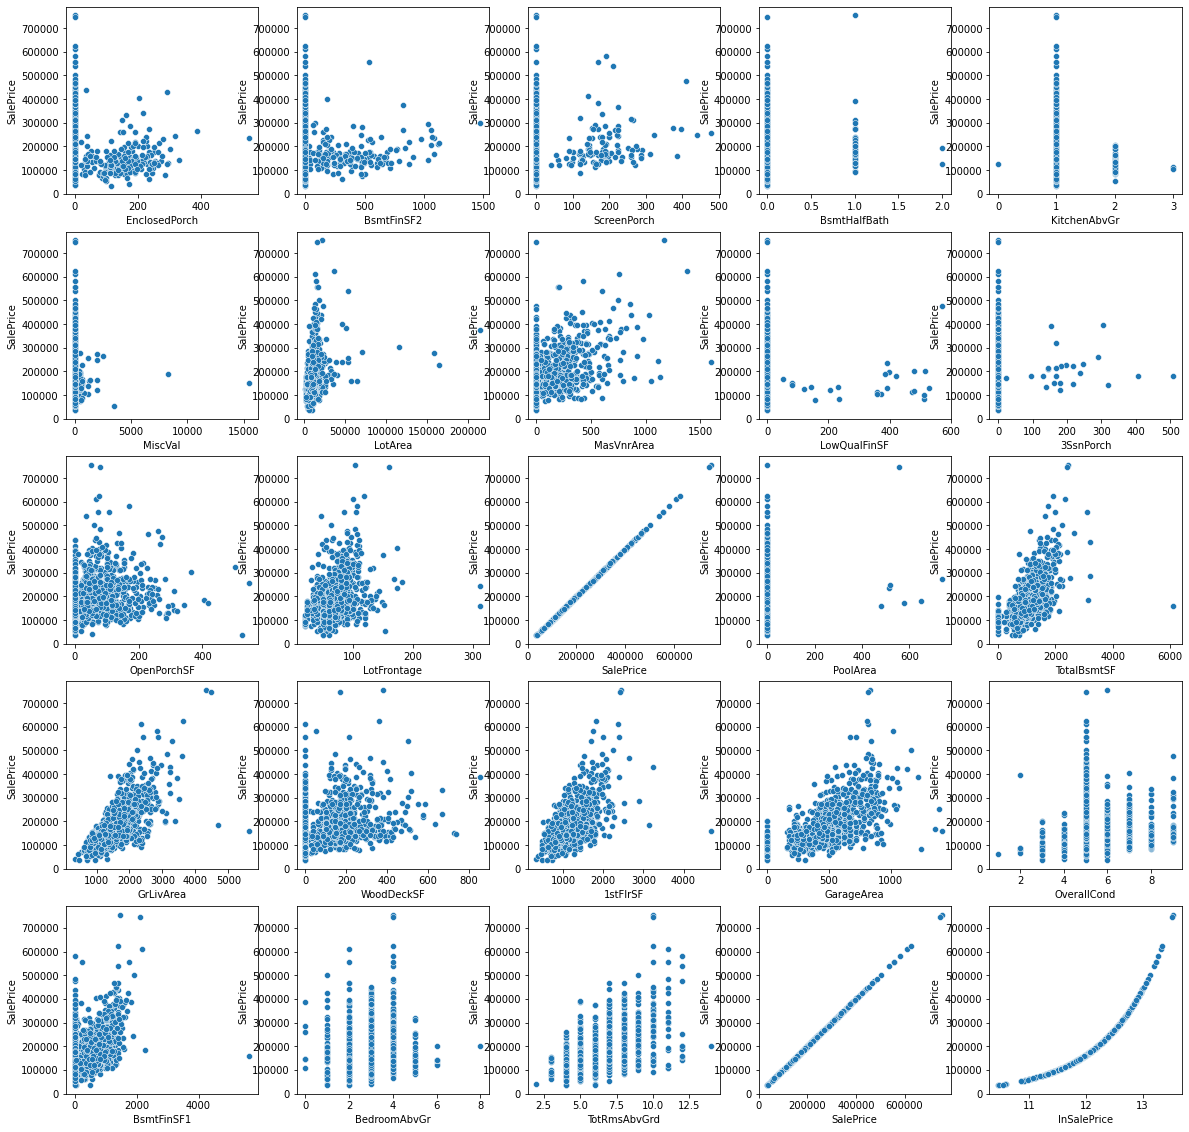

In [ ]:

outliers = ['EnclosedPorch', 'BsmtFinSF2', 'ScreenPorch', 'BsmtHalfBath', 'KitchenAbvGr', 'MiscVal',
            'LotArea', 'MasVnrArea', 'LowQualFinSF', '3SsnPorch', 'OpenPorchSF', 'LotFrontage', 
            'SalePrice', 'PoolArea', 'TotalBsmtSF', 'GrLivArea', 'WoodDeckSF', '1stFlrSF', 
            'GarageArea', 'OverallCond', 'BsmtFinSF1', 'BedroomAbvGr', 'TotRmsAbvGrd',
            'SalePrice', 'lnSalePrice']

fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(20,20))
for i in range(5):
  for j in range(5):
    n = 5*i + j
    sns.scatterplot(x=outliers[n], y='SalePrice', data=df_train, ax=axs[i, j])

#Quick note for what's going on in the code above:
# the plt.subplots command allows you to create a grid of graphs, in this case 5x5
# the i, j loops iterate, so that we populate each cell into the "ax=axs[i,j]" cell
# Note that there were 23 outliers, including sale price
# I didn't want to fight with the code for errors for the last two cells, so I just populated them w/ Sale and lnSale


### 2.2.3 Exclude Outliers as Appropriate

Reviewing the graphs above, there are only a handful of cases where the data truly look like outliers:
* LotFrontage > 200
* TotalBsmtSF > 4000
* GRLivArea > 4000 AND Sale Price <300000
* 1stFlrSF > 4000

The code below drops these fields.

Note that these thresholds result in 3 observations being dropped, so there is some overlap where individual observations triggered multiple outlier criteria.

Look to the original paper [here](http://jse.amstat.org/v19n3/decock.pdf): the author suggests removing all datapoints with above-ground livable area >4,000: these exclusions get close to the original author's intent.

In [ ]:
print(df_train.shape)
df_train = df_train.drop(df_train[df_train['LotFrontage'] > 200].index)
df_train = df_train.drop(df_train[df_train['TotalBsmtSF'] > 4000].index)
df_train = df_train.drop(df_train[(df_train['GrLivArea']>4000) & (df_train['SalePrice']<300000)].index)
df_train = df_train.drop(df_train[df_train['1stFlrSF'] > 4000].index)
print(df_train.shape)


(1460, 82)
(1457, 82)


## 3 IV ~ DV Correlation Research

Also as a way of doing some basic starts, we will look at which variables appear to be most highly correlated with sale price.

The homework assignment asks us to look at three fields.  I'll select two numeric and two categorical.

## 3.1 Numeric Fields

We'll use a correlation matrix to identify a few interesting fields for further research.

The code below pulls out the numeric fields with >0.5 correlation with SalePrice.  Note that "Sale Price" and "ln Sale Price" (created above) are triggreed.

The highest-correlated variables are:
* "OverallQual" (80% correlated)
* "GrLivArea" (73% correlated)


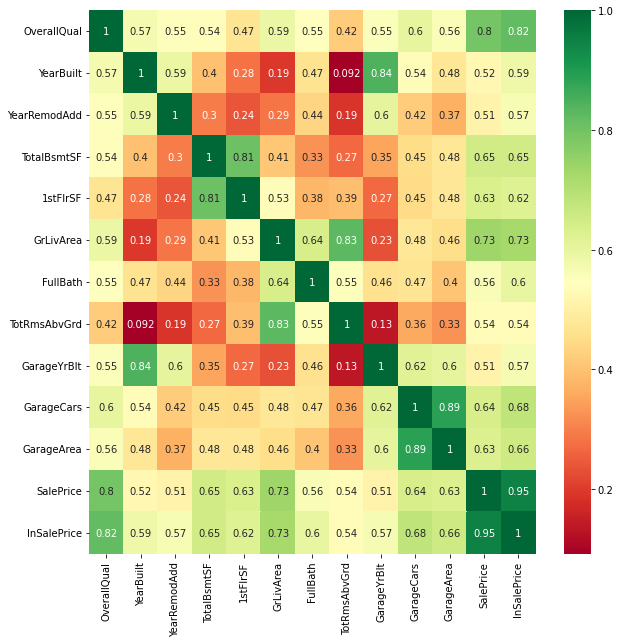

In [ ]:
# Thanks to https://www.kaggle.com/anupjana/top-10-ames-house-pricing-stacked-regression

corrmat = df_train.corr()
top_corr_features = corrmat.index[abs(corrmat["SalePrice"])>0.5] # the 0.5 is the cutoff for how related the variable should be
plt.figure(figsize=(10,10))
g = sns.heatmap(df_train[top_corr_features].corr(),annot=True,cmap="RdYlGn")

# 3.1.1 OverallQual

OverallQual is actually a categorical variable.  It is represented as a number, 1-10, with 1 = "Very Poor" and 10 = "Very Excellent."

The graphs below show that there is definitely an upward trend in sales price for higher quality.  Looking at the ln Sales, there isn't a lot of room for binning these, other than at the low end.

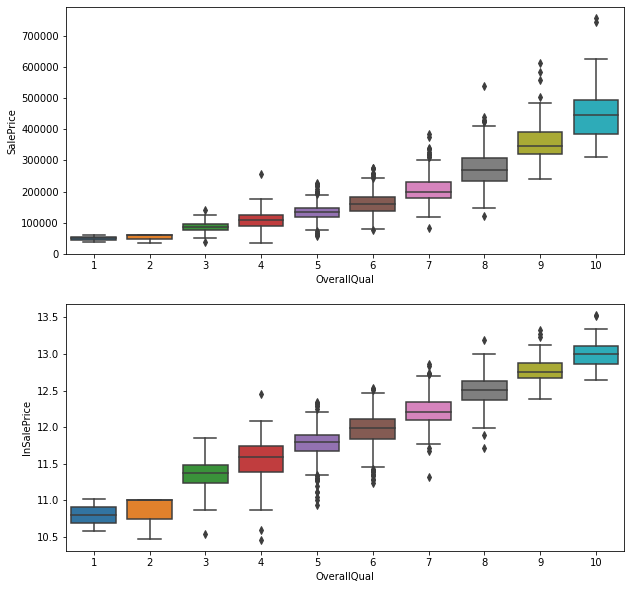

In [ ]:
def boxresearch(col):
  fig, axs = plt.subplots(nrows=2, figsize=(10,10))

  sns.boxplot(x=df_train[col], y = df_train['SalePrice'], ax = axs[0])
  sns.boxplot(x=df_train[col], y = df_train['lnSalePrice'], ax = axs[1])

boxresearch('OverallQual')


### 3.1.2 GrLivArea vs OverallQual

GrLivArea is the total livable square footage aboveground.  In theory, bigger = better.

To bring in some of that quality research, I color-code the scatterplot based on the quality score.  Note that some of the quality values get relatively thin, so I perform some basic binning here, with 1-3 as red, 4-6 as yellow, etc.

The striking conclusion here is that the yellows, greens, and some purples, all overlap in the livable area range of ~1300 to ~2500: in this range it seems like sale price is more strongly dictated by quality rather than by size.

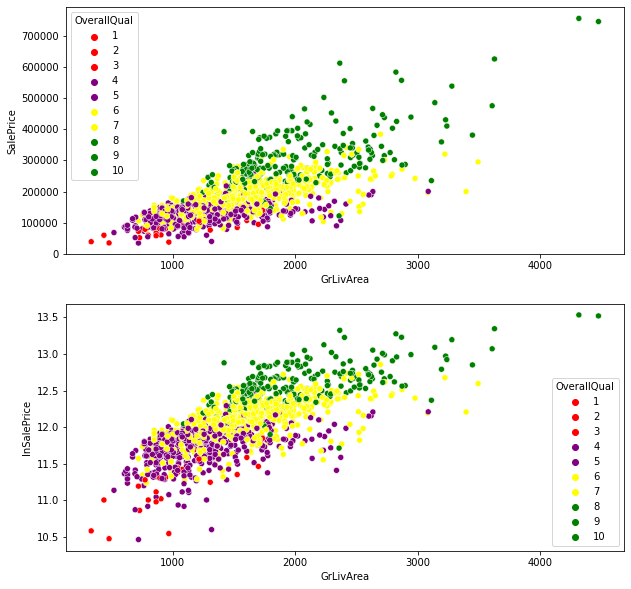

In [ ]:
fig, axs = plt.subplots(nrows=2, figsize=(10,10))

colors = ['red', 'red', 'red', 'purple', 'purple', 'yellow', 'yellow', 'green', 'green', 'green']
#colors = ['red', 'blue', 'cyan', 'yellow', 'purple', 'magenta', 'black', 'green', 'orange', 'purple']


sns.scatterplot(x=df_train['GrLivArea'], y = df_train['SalePrice'], hue = df_train['OverallQual'], palette = colors, ax = axs[0])
sns.scatterplot(x=df_train['GrLivArea'], y = df_train['lnSalePrice'], hue = df_train['OverallQual'], palette = colors, ax = axs[1])


### 3.1.2 GrLivArea vs OverallCond

GrLivArea is the total livable square footage aboveground.  In theory, bigger = better.

To bring in some of that quality research, I color-code the scatterplot based on the quality score.  Note that some of the quality values get relatively thin, so I perform some basic binning here, with 1-3 as red, 4-6 as yellow, etc.

The striking conclusion here is that the yellows, greens, and some purples, all overlap in the livable area range of ~1300 to ~2500: in this range it seems like sale price is more strongly dictated by quality rather than by size.

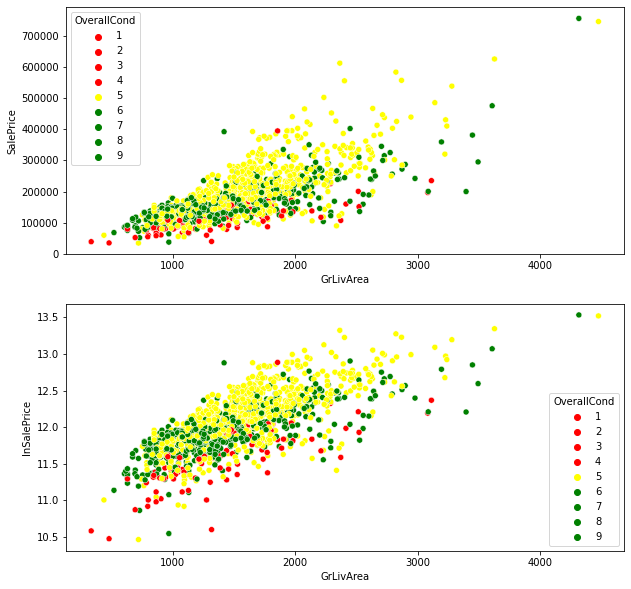

In [ ]:
fig, axs = plt.subplots(nrows=2, figsize=(10,10))

colors = ['red', 'red', 'red', 'red', 'yellow', 'green', 'green', 'green', 'green']
#colors = ['red', 'blue', 'cyan', 'yellow', 'purple', 'magenta', 'black', 'green', 'orange', 'purple']


sns.scatterplot(x=df_train['GrLivArea'], y = df_train['SalePrice'], hue = df_train['OverallCond'], palette = colors, ax = axs[0])
sns.scatterplot(x=df_train['GrLivArea'], y = df_train['lnSalePrice'], hue = df_train['OverallCond'], palette = colors, ax = axs[1])


## 3.2 Categorical Fields

For this stage we will grab a few categorical variables and try to identify whether there's a relationship.

Two immediately come to mind:
* Neighborhood.  Different areas probably have notably different sales expectations
* Month and/or Year Sold.  Two things going on here: first, there is well-known seasonality in home sales in the summer vs winter so we would expect to see some implication in sales price.  Second, the financial crisis happened in 2009 so we'd expect to see some drop in sales pre vs post.

### 3.2.1 Neighborhood Category

Yup.  Clearly a difference in sales price here.

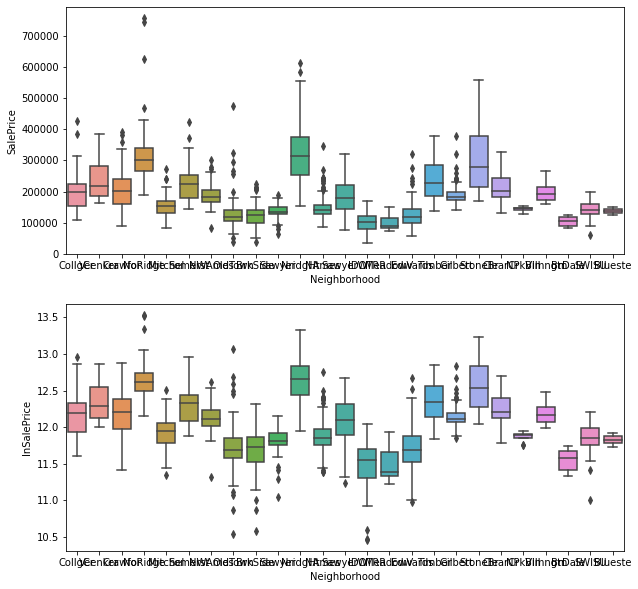

In [ ]:
boxresearch('Neighborhood')

### 3.2.2 Date Sold

I was really surprised that there's relatively little impact on sale price in 2006-2007 vs 2008, 2009, 2010.  Maybe Ames, Iowa is too small to have been materially affected by the downturn.

I created a Year-Month variable (Feature Selection!), and there's some strong discontinuity there.  It may be worth using Year-Month as a predictor rather than Year or Month on its own.

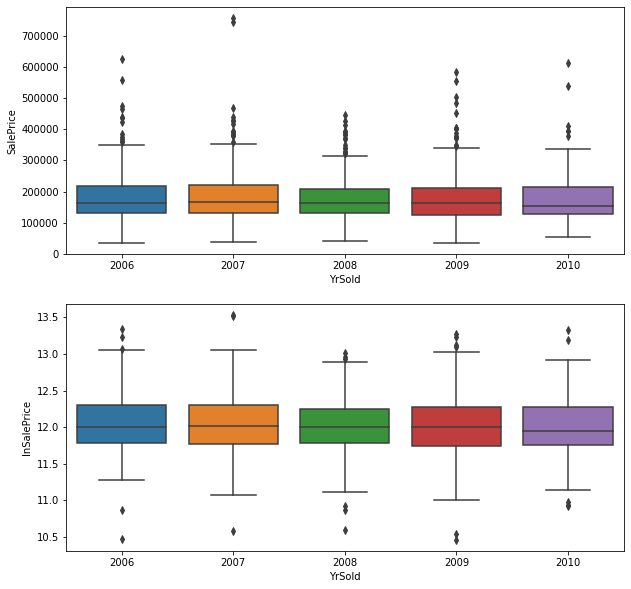

In [ ]:
boxresearch('YrSold')

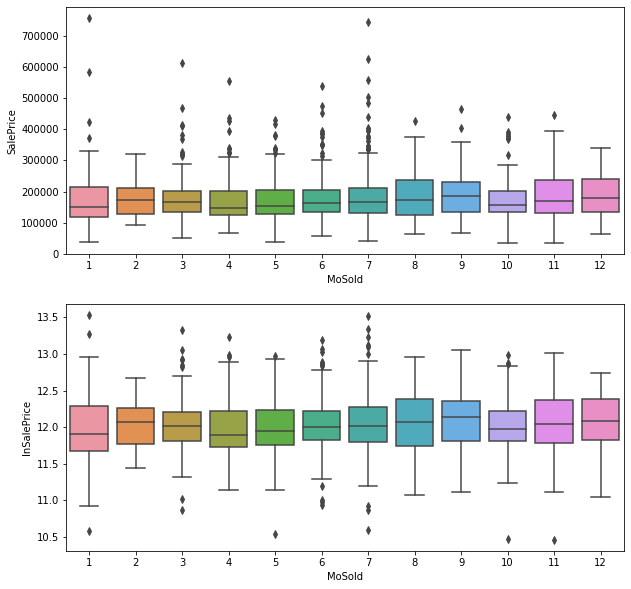

In [ ]:
boxresearch('MoSold')

# 4 Feature Generation

At the top of the house, we're going to combine test and train

## 4.1 Save Key data

In [ ]:
df_train_original = df_train.copy()
df_test_original = df_test.copy()
#Save the 'Id' column
train_ID = df_train['Id']
test_ID = df_test['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
df_train.drop("Id", axis = 1, inplace = True)
df_test.drop("Id", axis = 1, inplace = True)

# ntrain allows us to keep track of the length of the training set for later segmentation of train/test
ntrain = df_train.shape[0]

# This is where we implement the log-transform of the dependent variable, discussed above
y_train_orig = df_train.SalePrice.values
y_train = np.log(y_train_orig)

In [ ]:
df_all = pd.concat((df_train, df_test)).reset_index(drop=True)
df_all.drop(['SalePrice', 'lnSalePrice'], axis=1, inplace=True)

def printsize(frame):
  print('Size of dataset: {} rows, {} columns'.format(frame.shape[0], frame.shape[1]))

printsize(df_train)
printsize(df_test)
printsize(df_all)

Size of dataset: 1457 rows, 81 columns
Size of dataset: 1459 rows, 79 columns
Size of dataset: 2916 rows, 79 columns


## 4.2 Deal with Numerics

1. Create new fields permuting existing fields
2. Convert fields that are numeric but should be categorical

### 4.2.1 Create New Numeric Fields

Create the following new fields:
1. Age of house features
2. Square Footage aggregates

In [ ]:
df_all['HouseAge'] = df_all['YrSold'] - df_all['YearBuilt']
df_all['RemodelAge'] = df_all['YrSold'] - df_all['YearRemodAdd']
df_all['GarageAge'] = df_all['YrSold'] - df_all['GarageYrBlt']


In [ ]:
df_all['TotalSF'] = df_all['TotalBsmtSF'] + df_all['GrLivArea']
df_all['BsmtFinSF'] = df_all['BsmtFinSF1'] + df_all['BsmtFinSF2']
df_all['LivableSF'] = df_all['TotalSF'] - df_all['BsmtUnfSF']
df_all['PorchSF'] = df_all['ScreenPorch'] + df_all['EnclosedPorch'] + df_all['OpenPorchSF'] + df_all['WoodDeckSF'] + df_all['3SsnPorch']


In [ ]:
df_all['Fireplaces'][df_all['Fireplaces'] > 1] = 1
df_all['KitchenAbvGr'][df_all['KitchenAbvGr'] > 1] = 1

### 4.2.2 Convert Numerics to Text for Categorization

In [ ]:
#MSSubClass=The building class
df_all['MSSubClass'] = df_all['MSSubClass'].apply(str)

#Changing OverallCond into a categorical variable
df_all['OverallCond'] = df_all['OverallCond'].astype(str)
df_all['OverallQual'] = df_all['OverallCond'].astype(str)

#Year and month sold are transformed into categorical features.
df_all['YrSold'] = df_all['YrSold'].astype(str)
df_all['MoSold'] = df_all['MoSold'].astype(str)

## 4.3 Categoricals

Take all categorical variables and one-hot encode them

In [ ]:
cat_tracker = list(df_all.select_dtypes(exclude=['number']).columns)

In [ ]:
to_delete = []

def rem(term_cat):
  to_delete.append(term_cat)

def oh(term_cat, cat_prefix):
  df = pd.get_dummies(df_all[term_cat], prefix = cat_prefix, drop_first = True)
  to_delete.append(term_cat)
  return(df)

def oh_interact(term_cat, term_interact, cat_prefix):
  interact_prefix = term_interact + '_' + cat_prefix
  df1 = pd.get_dummies(df_all[term_cat], prefix = cat_prefix, drop_first = True)
  df2 = pd.get_dummies(df_all[term_cat], prefix = interact_prefix, drop_first = True)
  df2 = df2.mul(df_all[term_interact], axis = 0)
  df = df1.join(df2)
  to_delete.append(term_cat)
  return(df)

#X1 = oh_interact('OverallQual', 'LivableSF', 'OQ')
#X1.head()

#X2 = oh('MiscFeature', 'MF')
#X2.head()



In [ ]:
# The commented columns are all of the categoricals

#MSSubClass
rem('MSSubClass')
#MSZoning
X1 = oh('MSZoning', 'MSZ')
#Street
X2 = oh('Street', 'Street')
#Alley
X3 = oh('Alley', 'Alley')
#LotShape
X4 = oh_interact('LotShape', 'LotArea', 'Lot')
#LandContour
rem('LandContour')
#Utilities
X5 = oh('Utilities', 'Utilities')
#LotConfig
X6 = oh('LotConfig', 'LotConfig')
#LandSlope
X7 = oh_interact('LandSlope', 'LotArea', 'Land')
#Neighborhood
X8 = oh_interact('Neighborhood', 'LivableSF', 'NB')
#Condition1
X9 = oh('Condition1', 'Cond')
#Condition2
rem('Condition2')
#BldgType
X10 = oh_interact('BldgType', 'LivableSF', 'Bldg')
#HouseStyle
X11 = oh_interact('HouseStyle', 'LivableSF', 'Hse')
#OverallQual
X12 = oh_interact('OverallQual', 'LivableSF', 'OQ')
#OverallCond
X13 = oh_interact('OverallCond', 'LivableSF', 'OC')
#RoofStyle
rem('RoofStyle')
#RoofMatl
rem('RoofMatl')
#Exterior1st
X14 = oh('Exterior1st', 'Ex')
#Exterior2nd
rem('Exterior2nd')
#MasVnrType
X15 = oh_interact('MasVnrType', 'MasVnrArea', 'Veneer')
#ExterQual
X16 = oh('ExterQual', 'ExQual')
#ExterCond
X17 = oh('ExterCond', 'ExCond')
#Foundation
X18 = oh('Foundation', 'Fd')
#BsmtQual
X19 = oh_interact('BsmtQual', 'BsmtFinSF', 'BQ')
#BsmtCond
X20 = oh_interact('BsmtCond', 'BsmtFinSF', 'BC')
#BsmtExposure
X21 = oh('BsmtExposure', 'BE')
#BsmtFinType1
X22 = oh_interact('BsmtFinType1', 'BsmtFinSF', 'BF')
#BsmtFinType2
rem('BsmtFinType2')
#Heating
X23 = oh('Heating', 'Ht')
#HeatingQC
X24 = oh('HeatingQC', 'HtQC')
#CentralAir
X25 = oh('CentralAir', 'CA')
#Electrical
X26 = oh('Electrical', 'El')
#KitchenQual
X27 = oh('KitchenQual', 'KQ')
#Functional
X28 = oh('Functional', 'Func')
#FireplaceQu
X29 = oh_interact('FireplaceQu', 'Fireplaces', 'Fp')
#GarageType
X30 = oh_interact('GarageType', 'GarageArea', 'GT')
#GarageFinish
X31 = oh_interact('GarageFinish', 'GarageArea', 'GF')
#GarageQual
X32 = oh_interact('GarageQual', 'GarageArea', 'GQ')
#GarageCond
X33 = oh_interact('GarageCond', 'GarageArea', 'GC')
#PavedDrive
X34 = oh('PavedDrive', 'PD')
#PoolQC
rem('PoolQC')
#Fence
X35 = oh('Fence', 'Fence')
#MiscFeature
X36 = oh('MiscFeature', 'MF')
#MoSold
X37 = oh('MoSold', 'Month')
#YrSold
X38 = oh('YrSold', 'Year')
#SaleType
X39 = oh('SaleType', 'ST')
#SaleCondition
X40 = oh('SaleCondition', 'SC')

print(to_delete)

print(X36.head())
print(X20.head())



['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition']
   MF_None  MF_Othr  MF_Shed  MF_TenC
0        1        0        0        0
1        1        0        0        0
2        1        0        0        0
3        1        0        0        0
4        1        0        0        0
   BC_Gd  BC_None  BC_Po  ...  BsmtFinSF_BC_None  BsmtFinSF_BC_Po  BsmtFinSF_BC_TA
0      0        0      0  ...                

In [ ]:
df_all_backup = df_all.copy()

In [ ]:
#DATA = DATA.join([X1, X2, X3, X_CD, X8, X10])

df_all = df_all_backup.copy()

printsize(df_all)
df_all=df_all.drop(columns=to_delete)
printsize(df_all)

cols = [X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, 
        X11, X12, X13, X14, X15, X16, X17, X18, X19, X20, 
        X21, X22, X23, X24, X25, X26, X27, X28, X29, X30, 
        X31, X32, X33, X34, X35, X36, X37, X38, X39, X40]
df_all = df_all.join(cols)
printsize(df_all)

print(df_all.select_dtypes(exclude=np.number).shape)


Size of dataset: 2916 rows, 86 columns
Size of dataset: 2916 rows, 38 columns
Size of dataset: 2916 rows, 344 columns
(2916, 0)


In [ ]:
df_train = df_all[:ntrain]
df_test = df_all[ntrain:]

printsize(df_train)
printsize(df_test)

Size of dataset: 1457 rows, 344 columns
Size of dataset: 1459 rows, 344 columns


# 5 Build Models

Big thanks to https://www.kaggle.com/anupjana/top-10-ames-house-pricing-stacked-regression for code examples

## 5.1 Import Model Libraries and Define Methods

In [ ]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC, Ridge
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PowerTransformer
from sklearn.decomposition import PCA
import xgboost as xgb
import lightgbm as lgb

In [ ]:
#Validation function
n_folds = 5

def kfold_cv_rmsle(model, X, y):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X.values)
    rmsle = np.sqrt(-cross_val_score(model, X.values, y, scoring="neg_mean_squared_error", cv = kf))
    return(rmsle)

def kfold_cv_pred(model, X, y):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X.values)
    y_pred = cross_val_predict(model, X.values, y, cv=kf)

    return(y_pred)

In [ ]:
scaler = MinMaxScaler()
#scaler = RobustScaler()
power = PowerTransformer(method = 'yeo-johnson', standardize = False)
pca = PCA(n_components = 10)

In [ ]:
use_best = False # This is a toggle for whether the code should use the last best run or size them out again

ridge_alphas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
if use_best:
  ridge_alphas = [1] # This line overwrites the outcomes of the ridge_alphas below, since 1 performed the best
best_ridge_score = 1000
best_rigde_alpha = 0

for alpha_touse in ridge_alphas:
#  KRR = KernelRidge(alpha= alpha_touse, kernel='polynomial', degree=2, coef0=2.5)
  RR = Ridge(alpha = alpha_touse)
  RR_pipe = make_pipeline(power, scaler, RR)
  score = kfold_cv_rmsle(RR_pipe, df_train, y_train)
  if score.mean() < best_ridge_score:
    best_ridge_score = score.mean()
    best_ridge_alpha = alpha_touse
  print("Alpha: {:.4f}, Ridge score: {:.4f} ({:.4f})\n".format(alpha_touse, score.mean(), score.std()))

ridge_alphas_multipliers = np.array([0.2, 0.5, 0.8, 1, 1.3, 2, 5, 8])
ridge_alphas = best_ridge_alpha * ridge_alphas_multipliers
if use_best:
  ridge_alphas = [2] # This line overwrites the outcomes of the ridge_alphas below, since 2 performed the best

for alpha_touse in ridge_alphas:
#  KRR = KernelRidge(alpha= alpha_touse, kernel='polynomial', degree=2, coef0=2.5)
  RR = Ridge(alpha = alpha_touse)
  RR_pipe = make_pipeline(power, scaler, RR)
  score = kfold_cv_rmsle(RR_pipe, df_train, y_train)
  if score.mean() < best_ridge_score:
    best_ridge_score = score.mean()
    best_ridge_alpha = alpha_touse
  print("Alpha: {:.4f}, Ridge score: {:.4f} ({:.4f})\n".format(alpha_touse, score.mean(), score.std()))

print("Best Ridge Alpha: {:.4f}, Best Ridge score: {:.4f})\n".format(best_ridge_alpha, best_ridge_score))



Alpha: 0.0000, Ridge score: 0.2035 (0.1238)

Alpha: 0.0001, Ridge score: 0.1376 (0.0196)

Alpha: 0.0010, Ridge score: 0.1292 (0.0119)

Alpha: 0.0100, Ridge score: 0.1285 (0.0115)

Alpha: 0.1000, Ridge score: 0.1257 (0.0101)

Alpha: 1.0000, Ridge score: 0.1224 (0.0073)

Alpha: 10.0000, Ridge score: 0.1235 (0.0056)

Alpha: 100.0000, Ridge score: 0.1521 (0.0086)

Alpha: 0.2000, Ridge score: 0.1247 (0.0093)

Alpha: 0.5000, Ridge score: 0.1233 (0.0081)

Alpha: 0.8000, Ridge score: 0.1226 (0.0075)

Alpha: 1.0000, Ridge score: 0.1224 (0.0073)

Alpha: 1.3000, Ridge score: 0.1221 (0.0070)

Alpha: 2.0000, Ridge score: 0.1218 (0.0065)

Alpha: 5.0000, Ridge score: 0.1220 (0.0058)

Alpha: 8.0000, Ridge score: 0.1228 (0.0056)

Best Alpha: 2.0000, Best Ridge score: 0.1218)



In [ ]:
use_best = False # This is a toggle for whether the code should use the last best run or size them out again

lasso_alphas = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
if use_best:
  lasso_alphas = [.0001] # This line overwrites the outcomes of the ridge_alphas below, since this performed the best
best_lasso_score = 1000
best_lasso_alpha = 0

for alpha_touse in lasso_alphas:
  lasso = make_pipeline(power, scaler, Lasso(alpha = alpha_touse, random_state=1))
  score = kfold_cv_rmsle(lasso, df_train, y_train)
  if score.mean() < best_lasso_score:
    best_lasso_score = score.mean()
    best_lasso_alpha = alpha_touse
  print("Alpha: {:.6f}, Lasso score: {:.4f} ({:.4f})\n".format(alpha_touse, score.mean(), score.std()))

lasso_alphas_multipliers = np.array([0.2, 0.5, 0.8, 1, 1.3, 2, 5, 8])
lasso_alphas = best_lasso_alpha * lasso_alphas_multipliers
if use_best:
  lasso_alphas = [0.0002] # This line overwrites the outcomes of the ridge_alphas below

for alpha_touse in lasso_alphas:
  lasso = make_pipeline(power, scaler, Lasso(alpha = alpha_touse, random_state=1))
  score = kfold_cv_rmsle(lasso, df_train, y_train)
  if score.mean() < best_lasso_score:
    best_lasso_score = score.mean()
    best_lasso_alpha = alpha_touse
  print("Alpha: {:.6f}, Lasso score: {:.4f} ({:.4f})\n".format(alpha_touse, score.mean(), score.std()))

print("Best Lasso Alpha: {:.4f}, Best Lasso score: {:.4f})\n".format(best_lasso_alpha, best_lasso_score))


Alpha: 0.000001, Lasso score: 0.1290 (0.0119)

Alpha: 0.000010, Lasso score: 0.1268 (0.0111)

Alpha: 0.000100, Lasso score: 0.1196 (0.0071)

Alpha: 0.001000, Lasso score: 0.1222 (0.0058)

Alpha: 0.010000, Lasso score: 0.1795 (0.0115)

Alpha: 0.100000, Lasso score: 0.3810 (0.0170)

Alpha: 1.000000, Lasso score: 0.3995 (0.0160)

Alpha: 10.000000, Lasso score: 0.3995 (0.0160)

Alpha: 100.000000, Lasso score: 0.3995 (0.0160)

Alpha: 0.000020, Lasso score: 0.1252 (0.0099)

Alpha: 0.000050, Lasso score: 0.1224 (0.0083)

Alpha: 0.000080, Lasso score: 0.1205 (0.0075)

Alpha: 0.000100, Lasso score: 0.1196 (0.0071)

Alpha: 0.000130, Lasso score: 0.1186 (0.0069)

Alpha: 0.000200, Lasso score: 0.1178 (0.0066)

Alpha: 0.000500, Lasso score: 0.1194 (0.0056)

Alpha: 0.000800, Lasso score: 0.1207 (0.0057)

Best Alpha: 0.0002, Best Lasso score: 0.1178)



In [ ]:
use_best = False # This is a toggle for whether the code should use the last best run or size them out again

parametersGrid = {"alpha": [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                  "l1_ratio": np.arange(0.0, 1.0, 0.1)}

en_alpha = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
en_l1 = np.arange(0.0, 1.0, 0.1)

if use_best:
  en_alpha = [0.001]
  en_l1 = [0.2]
en_best_score = 10000
en_best_alpha = 0
en_best_l1 = 0

for alpha in en_alpha:
  for l1 in en_l1:
    ENet = make_pipeline(power, scaler, ElasticNet(alpha=alpha, l1_ratio=l1, random_state=3))
    score = kfold_cv_rmsle(ENet, df_train, y_train)
    if score.mean() < en_best_score:
      en_best_alpha = alpha
      en_best_l1 = l1
      en_best_score = score.mean()
    print("Alpha: {:.6f}, l1_ratio: {:.1f}, ElasticNet score: {:.4f} ({:.4f})\n".format(alpha, l1, score.mean(), score.std()))

Alpha: 0.000100, l1_ratio: 0.0, ElasticNet score: 0.1255 (0.0100)

Alpha: 0.000100, l1_ratio: 0.1, ElasticNet score: 0.1248 (0.0096)

Alpha: 0.000100, l1_ratio: 0.2, ElasticNet score: 0.1239 (0.0092)

Alpha: 0.000100, l1_ratio: 0.3, ElasticNet score: 0.1233 (0.0088)

Alpha: 0.000100, l1_ratio: 0.4, ElasticNet score: 0.1226 (0.0084)

Alpha: 0.000100, l1_ratio: 0.5, ElasticNet score: 0.1220 (0.0081)

Alpha: 0.000100, l1_ratio: 0.6, ElasticNet score: 0.1214 (0.0079)

Alpha: 0.000100, l1_ratio: 0.7, ElasticNet score: 0.1208 (0.0076)

Alpha: 0.000100, l1_ratio: 0.8, ElasticNet score: 0.1204 (0.0075)

Alpha: 0.000100, l1_ratio: 0.9, ElasticNet score: 0.1200 (0.0073)

Alpha: 0.001000, l1_ratio: 0.0, ElasticNet score: 0.1222 (0.0071)

Alpha: 0.001000, l1_ratio: 0.1, ElasticNet score: 0.1195 (0.0062)

Alpha: 0.001000, l1_ratio: 0.2, ElasticNet score: 0.1187 (0.0062)

Alpha: 0.001000, l1_ratio: 0.3, ElasticNet score: 0.1188 (0.0058)

Alpha: 0.001000, l1_ratio: 0.4, ElasticNet score: 0.1192 (0.00

In [118]:
en_alphas_multipliers = np.array([0.2, 0.5, 0.8, 1, 1.3, 2, 5, 8])
en_alpha = en_best_alpha * en_alphas_multipliers
en_l1_scalars = np.array([-0.08, -0.06, -0.04, -0.02, 0, 0.02, 0.04, 0.06, 0.08])
en_l1 = en_l1_scalars + en_best_l1

for alpha in en_alpha:
  for l1 in en_l1:
    ENet = make_pipeline(power, scaler, ElasticNet(alpha=alpha, l1_ratio=l1, random_state=3))
    score = kfold_cv_rmsle(ENet, df_train, y_train)
    if score.mean() < en_best_score:
      en_best_alpha = alpha
      en_best_l1 = l1
      en_best_score = score.mean()
    print("Alpha: {:.6f}, l1_ratio: {:.2f}, ElasticNet score: {:.4f} ({:.4f})\n".format(alpha, l1, score.mean(), score.std()))

print('Best Alpha / l1 / score:', en_best_alpha, en_best_l1, en_best_score)

Alpha: 0.000200, l1_ratio: 0.12, ElasticNet score: 0.1228 (0.0085)

Alpha: 0.000200, l1_ratio: 0.14, ElasticNet score: 0.1226 (0.0084)

Alpha: 0.000200, l1_ratio: 0.16, ElasticNet score: 0.1223 (0.0082)

Alpha: 0.000200, l1_ratio: 0.18, ElasticNet score: 0.1221 (0.0081)

Alpha: 0.000200, l1_ratio: 0.20, ElasticNet score: 0.1219 (0.0080)

Alpha: 0.000200, l1_ratio: 0.22, ElasticNet score: 0.1217 (0.0079)

Alpha: 0.000200, l1_ratio: 0.24, ElasticNet score: 0.1215 (0.0079)

Alpha: 0.000200, l1_ratio: 0.26, ElasticNet score: 0.1214 (0.0078)

Alpha: 0.000200, l1_ratio: 0.28, ElasticNet score: 0.1212 (0.0077)

Alpha: 0.000500, l1_ratio: 0.12, ElasticNet score: 0.1203 (0.0069)

Alpha: 0.000500, l1_ratio: 0.14, ElasticNet score: 0.1200 (0.0068)

Alpha: 0.000500, l1_ratio: 0.16, ElasticNet score: 0.1198 (0.0067)

Alpha: 0.000500, l1_ratio: 0.18, ElasticNet score: 0.1195 (0.0066)

Alpha: 0.000500, l1_ratio: 0.20, ElasticNet score: 0.1193 (0.0066)

Alpha: 0.000500, l1_ratio: 0.22, ElasticNet scor

# 6 Forecast on Test Set

This step takes the three models defined above (Ridge, Lasso, ElasticNet), applies the models using the best-performing alpha (and L1 ratio for EN) to the full train set, and then builds the forecast on the test set.

We then create a weighted average of model performance.  Ridge performed the worst, so we weight the end forecast at 1*Ridge + 2*Lasso + 2*ElasticNet

#6.1 Build best models on train set

In [122]:
RidgeBest = make_pipeline(power, scaler, Ridge(alpha = best_ridge_alpha))
LassoBest = make_pipeline(power, scaler, Lasso(alpha = best_lasso_alpha))
ElNetBest = make_pipeline(power, scaler, ElasticNet(alpha=en_best_alpha, l1_ratio=en_best_l1))

#LassoMd = lasso.fit(final_train_df.values,y_train)

RidgeMd = RidgeBest.fit(df_train, y_train)
LassoMd = LassoBest.fit(df_train, y_train)
ElNetMd = ElNetBest.fit(df_train, y_train)



In [126]:
Lasso_train_pred = LassoMd.predict(df_train)
ElNet_train_pred = ElNetMd.predict(df_train)
Ridge_train_pred = RidgeMd.predict(df_train)

avg_train_pred = (Lasso_train_pred + ElNet_train_pred + Ridge_train_pred) / 3

avg_rmsle = np.sqrt(mean_squared_error(y_train, avg_train_pred))
print("Average Model RMSLE score: {:.4f}".format(avg_rmsle))

avg_train_pred = np.exp(avg_train_pred)
avg_train_pred

Average Model RMSLE score: 0.0996


array([203944.74605354, 198688.19035368, 214401.68740446, ...,
       274147.50826099, 142828.84493064, 153077.73567217])

In [127]:
Lasso_test_pred = LassoMd.predict(df_test)
ElNet_test_pred = ElNetMd.predict(df_test)
Ridge_test_pred = RidgeMd.predict(df_test)

avg_test_pred = (Lasso_test_pred + ElNet_test_pred + Ridge_test_pred) / 3
final_pred = np.exp(avg_test_pred)
final_pred

array([115210.05613556, 155018.83507213, 192439.73242408, ...,
       166038.25617628, 120731.57416501, 214194.98028685])

In [129]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = final_pred
#sub.to_csv('Wk3sub1.csv',index=False)